# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Introduction

When warmer temperatures and longer days arrive, one of the highlights of this season start to appear: Festivals! Who does not have really good stories in festivals during the warmer months of the year? But, are the number of festivals in Europe somehow related to temperature? In this analysis we will try to find out if there's any correlation between monthly temperatures in cities spread over Europe and the number of festivals they held. For that reason, we will first cluster the list of cities by temperature and check the average number of festivals per cluster. 

Are you thinking about creating a new open-air festival? This analysis might help you decide.

## Data

In this analysis we will use mean monthly temperatures extracted from [Wikipedia](https://en.wikipedia.org/wiki/List_of_cities_by_average_temperature) and foursquare data of festivals in the different locations.

For the temperatures, I will extract the data using BeautifulSoup and create a Pandas Dataframe. I will later use KNN clustering to cluster the data based on temperatures. In the last step I will get the number of festivals per location in a 10 Km radius and check if there is any correlation to the different clusters.

## Methodology

First of all, let's import all necessary packages to conduct our research and define a function to manipulate strings and get only temperature in degrees Celsius 

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import folium
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim

In [2]:
def func(string):
    a_new_string =string.split('(')[0] 
    return a_new_string

We will use Pandas to directly read the tabular wikipedia data into a dataframe. For that we will define the url and read in the data. Finally, we will clean the dataframe.

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_cities_by_average_temperature'

df_list = pd.read_html(url, flavor='bs4')

## As the dataframe is a list of dataframes we will select the one corresponding to Europe
dfeurope= df_list[2]
dfeurope.drop('Ref.', axis=1, inplace=True)

## Remove temperatures in Farenheit
for col in dfeurope.columns:
    dfeurope[col] = dfeurope[col].apply(func)
    

Some city names in the dataframe will lead into wrong coordinate extraction. In this case we will modify the name to be sure be are pulling the right coordinates. 

In [4]:
dfeurope.replace('Sofia', 'Sofiya', inplace=True)
dfeurope.replace('Cracow', 'Krakow', inplace=True)

Let's take a look at the dataframe and do a quick check to see that everything is as expected

In [5]:
dfeurope

,Country,City,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year
0,Albania,Tirana,6.7,7.8,10.0,13.4,18.0,21.6,24.0,23.8,20.7,16.0,11.7,8.1,15.2
1,Andorra,Andorra la Vella,2.2,3.5,5.8,7.5,11.5,15.4,18.8,18.5,14.9,10.3,5.7,3.0,9.8
2,Austria,Vienna,0.3,1.5,5.7,10.7,15.7,18.7,20.8,20.2,15.4,10.2,5.1,1.1,10.4
3,Belarus,Minsk,−4.5,−4.4,0.0,7.2,13.3,16.4,18.5,17.5,12.1,6.6,0.6,−3.4,6.7
4,Belgium,Brussels,3.3,3.7,6.8,9.8,13.6,16.2,18.4,18.0,14.9,11.1,6.8,3.9,10.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Ukraine,Kiev,−3.5,−3.0,1.8,9.3,15.5,18.5,20.5,19.7,14.2,8.4,1.9,−2.3,8.4
66,Ukraine,Lviv,−3.1,−2.2,1.9,8.3,13.8,16.4,18.3,17.7,13.0,8.1,2.6,−1.8,7.8
67,Ukraine,Odessa,−0.5,−0.2,3.5,9.4,15.6,20.0,22.6,22.3,17.2,11.6,5.7,1.1,10.7
68,United Kingdom,Edinburgh,4.2,4.5,6.2,8.1,10.8,13.5,15.3,15.2,13.0,9.8,6.7,4.2,9.3


In [6]:
dfeurope.dtypes

Country    object
City       object
Jan        object
Feb        object
Mar        object
Apr        object
May        object
Jun        object
Jul        object
Aug        object
Sep        object
Oct        object
Nov        object
Dec        object
Year       object
dtype: object

As you can see, the negative sign is not interpreted as such when importing the data. Also, this leads into a wrong data type in the numeric columns. Finally, we will get rid of the 'Year' and 'Country' columns. Let's fix this!

In [7]:
dfeurope.replace('−','-',regex=True, inplace = True)

dfeurope.drop('Country', axis=1, inplace=True)
dfeurope.drop('Year', axis=1, inplace=True)

for col in dfeurope.columns:
    if col == 'City':
        pass
    else:
        dfeurope[col] = pd.to_numeric(dfeurope[col],errors='coerce')

In [8]:
dfeurope

,City,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Tirana,6.7,7.8,10.0,13.4,18.0,21.6,24.0,23.8,20.7,16.0,11.7,8.1
1,Andorra la Vella,2.2,3.5,5.8,7.5,11.5,15.4,18.8,18.5,14.9,10.3,5.7,3.0
2,Vienna,0.3,1.5,5.7,10.7,15.7,18.7,20.8,20.2,15.4,10.2,5.1,1.1
3,Minsk,-4.5,-4.4,0.0,7.2,13.3,16.4,18.5,17.5,12.1,6.6,0.6,-3.4
4,Brussels,3.3,3.7,6.8,9.8,13.6,16.2,18.4,18.0,14.9,11.1,6.8,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Kiev,-3.5,-3.0,1.8,9.3,15.5,18.5,20.5,19.7,14.2,8.4,1.9,-2.3
66,Lviv,-3.1,-2.2,1.9,8.3,13.8,16.4,18.3,17.7,13.0,8.1,2.6,-1.8
67,Odessa,-0.5,-0.2,3.5,9.4,15.6,20.0,22.6,22.3,17.2,11.6,5.7,1.1
68,Edinburgh,4.2,4.5,6.2,8.1,10.8,13.5,15.3,15.2,13.0,9.8,6.7,4.2


In [9]:
dfeurope.dtypes

City     object
Jan     float64
Feb     float64
Mar     float64
Apr     float64
May     float64
Jun     float64
Jul     float64
Aug     float64
Sep     float64
Oct     float64
Nov     float64
Dec     float64
dtype: object

Much better now! Negative signs are now correct and the data type of the numeric columns is correct. 

The next step is to get the coordinates of each city. 

In [10]:
geolocator = Nominatim(user_agent="test")
cities = dfeurope['City']

locations = []
for c in cities:
    locations.append(geolocator.geocode(c))
    
latitudes = [x[0] for x in [x[1] for x in locations]]
longitudes = [x[1] for x in [x[1] for x in locations]]

dfeurope['Lat'] = latitudes
dfeurope['Long'] = longitudes

dfeurope

,City,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Lat,Long
0,Tirana,6.7,7.8,10.0,13.4,18.0,21.6,24.0,23.8,20.7,16.0,11.7,8.1,41.327948,19.818551
1,Andorra la Vella,2.2,3.5,5.8,7.5,11.5,15.4,18.8,18.5,14.9,10.3,5.7,3.0,42.506939,1.521247
2,Vienna,0.3,1.5,5.7,10.7,15.7,18.7,20.8,20.2,15.4,10.2,5.1,1.1,48.208354,16.372504
3,Minsk,-4.5,-4.4,0.0,7.2,13.3,16.4,18.5,17.5,12.1,6.6,0.6,-3.4,53.902334,27.561879
4,Brussels,3.3,3.7,6.8,9.8,13.6,16.2,18.4,18.0,14.9,11.1,6.8,3.9,50.846557,4.351697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Kiev,-3.5,-3.0,1.8,9.3,15.5,18.5,20.5,19.7,14.2,8.4,1.9,-2.3,50.450034,30.524136
66,Lviv,-3.1,-2.2,1.9,8.3,13.8,16.4,18.3,17.7,13.0,8.1,2.6,-1.8,49.841952,24.031592
67,Odessa,-0.5,-0.2,3.5,9.4,15.6,20.0,22.6,22.3,17.2,11.6,5.7,1.1,46.487319,30.739278
68,Edinburgh,4.2,4.5,6.2,8.1,10.8,13.5,15.3,15.2,13.0,9.8,6.7,4.2,55.953346,-3.188375


Let's visualize the data we have so far

In [16]:
# create map
map_clusters = folium.Map(location=[dfeurope['Lat'][0], dfeurope['Long'][0]], zoom_start=3)

for lat, lon, poi in zip(dfeurope['Lat'], dfeurope['Long'], dfeurope['City']):
    label = folium.Popup(str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's also check the monthly temperatures to see if we can already see some insights in the data.

In [13]:
temp_check = dfeurope.drop(['City','Lat','Long'], axis=1)

Text(0.5, 1.0, 'Monthly average Temperatures')

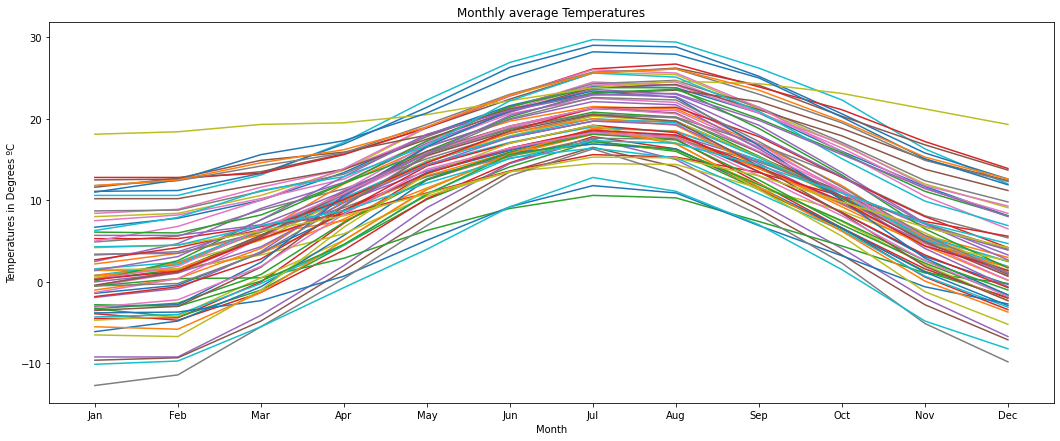

In [15]:
f, ax = plt.subplots(figsize=(18, 7))
plt.plot(temp_check.T)
ax.set(xlabel='Month', ylabel='Temperatures in Degrees ºC')
plt.title('Monthly average Temperatures')

Most of the temperatures follow the same shape with the exception of one city. This is due to the fact that Las Palmas de Gran Canarias in the Canary Islands have a sub-tropical climate. This might affect the results so we decide to remove this entry from the dataset.

In [18]:
dfeurope = dfeurope[~dfeurope.City.str.contains("Las Palmas de Gran Canaria")]

Now it is time to start the machine learning process. 

## Results

## Discussion

## Conclusion